In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

#for replicability purposes
tf.random.set_seed(91195003)
#for an easy reset backend session state
tf.keras.backend.clear_session()

In [ ]:
#Load dataset
def load_dataset(path):
  return pd.read_csv(path)

In [ ]:
#split data into training and validation sets
def split_data(training, perc=10):
  train_idx = np.arange(0, int(len(training)*(100-perc)/100))
  val_idx = np.arange(int(len(training)*(100-perc)/100+1), len(training))
  return train_idx, val_idx

In [ ]:
# Prepare data to be predicted
def prepare_data(df):
  df_aux = df.copy()
  df_aux = df_aux.set_index('Date')
  return df_aux

In [ ]:

#Normalize the data
def data_normalization(df, norm_range=(-1, 1)):
  #[-1, 1] for LSTM due to the internal use of tanh by the memory cell
  scaler = MinMaxScaler(feature_range=norm_range)
  df[['All_Causes']] = scaler.fit_transform(df[['All_Causes']])
  df[['Diabetes']] = scaler.fit_transform(df[['Diabetes']])
  df[['Ozone']] = scaler.fit_transform(df[['Ozone']])
  df[['Temperature']] = scaler.fit_transform(df[['Temperature']])

  return scaler

In [ ]:
#plot learning curve
def plot_learning_curves(history, epochs):
  loss=history.history['loss']
  val_loss=history.history['val_loss']
  epochs_range = range(epochs)
  #creating figure
  plt.figure(figsize=(8,8))
  plt.subplot(1,2,2)
  plt.plot(epochs_range,loss,label='Training Loss')
  plt.plot(epochs_range,val_loss,label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training/Validation Loss')
  plt.show()

In [ ]:
#Plot time series data
def plot_confirmed_cases(data):
  plt.figure(figsize=(8,6))
  plt.plot(range(len(data)), data)
  plt.title('Confirmed Deaths')
  plt.ylabel('Óbitos')
  plt.xlabel('Days')
  plt.show()

In [ ]:
#Preparing the dataset for the LSTM
def to_supervised(df, timesteps):
  data = df.values
  X, y = list(), list()
  #iterate over the training set to create X and y
  dataset_size = len(data)
  for curr_pos in range(dataset_size):
    #end of the input sequence is the current position + the number of timesteps of the input sequence
    input_index = curr_pos + timesteps
    #end of the labels corresponds to the end of the input sequence + 1
    label_index = input_index + 1
    #if we have enough data for this sequence
    if label_index < dataset_size:
      X.append(data[curr_pos:input_index, :])
      y.append(data[input_index:label_index, 1])
  #using np.float32 for GPU performance
  return np.array(X).astype('float32'), np.array(y).astype('float32')

In [ ]:
#Building the model
def rmse(y_true, y_pred):
  return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))

def build_model(timesteps, features, h_neurons=64, activation='tanh'):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.LSTM(h_neurons, activation=activation, input_shape=(timesteps, features), return_sequences=True))
  #Add a new layer
  model.add(tf.keras.layers.LSTM(32, activation=activation ,return_sequences=False))
  #
  model.add(tf.keras.layers.Dense(h_neurons, activation=activation))
  model.add(tf.keras.layers.Dense(1, activation='linear'))
  #model summary (and save it as PNG)
  tf.keras.utils.plot_model(model, 'covid_model.png', show_shapes=True)
  return model

In [ ]:
#Compiling and fit the model
def compile_and_fit(model, epochs, batch_size):
  #compile
  model.compile(loss = rmse, optimizer = tf.keras.optimizers.Adam(), metrics = ['mae', rmse])
  #fit
  hist_list = list()
  loss_list = list()

  #callback
  #saving in Keras HDF5 (or h5), a binary data format
  callbacks = [tf.keras.callbacks.ModelCheckpoint(
        filepath='my_model_{epoch}_{val_loss:.3f}.h5',#path where to save model
        save_best_only=True,#overwrite the current checkpoint if and only if
        monitor='val_loss',#the val_loss score has improved
        save_weights_only=False,#if True, only the weigths are saved
        verbose=1,#verbosity mode
        period=5 #save ony at the fifth epoch (5 em 5 epocas)
        )#,
    #interrupt training if loss stops improving for over 2 epochs
    #tf.keras.callbacks.EarlyStopping(patience=9, monitor='cost')
    ]

  #Time Series Cross Validator
  tscv = TimeSeriesSplit(n_splits=cv_splits)
  for train_index, test_index in tscv.split(X):
    train_idx, val_idx = split_data(train_index, perc=10) #further split into training and validation sets
    #build data
    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]
    X_test, y_test = X[test_index], y[test_index]

    #print("x_val::::",X_val,"\n","y_val:",y_val,"\n")

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=epochs, batch_size=batch_size, shuffle=False, callbacks=callbacks)
    metrics = model.evaluate(X_test, y_test)


    plot_learning_curves(history, epochs)
    hist_list.append(history)


  return model, hist_list

In [ ]:
  # Recursive Multi-Step Forecast!!!
def forecast(model, df, timesteps, multisteps, scaler):
    input_seq = np.array(df[-timesteps:].values)  # getting the last sequence of known value
    inp = input_seq
    # print("Input_seq: ",inp)
    forecasts = list()

    # multisteps tells us how many iterations we want to perform, i.e., how many days we want to predict
    for step in range(1, multisteps + 1):
      inp = inp.reshape(1, timesteps, n_variate)
      yhat = model.predict(inp)  # dá o valor predito normalizado
      yhat_desnormalized = scaler.inverse_transform(yhat)  # dá valor predito desnormalizado
      forecasts.append(yhat_desnormalized)  # adicionar previsao à lista final de previsões

    return forecasts

In [ ]:
def plot_forecast(data, forecasts):

    plt.figure(figsize=(8, 6))
    plt.plot(range(len(data)), data['obitos'], color='green', label='True value')
    plt.plot(range(len(data) - 1, len(data) + len(forecasts) - 1), forecasts, color='red', label='Forecasts')
    plt.title('Number of deaths')
    plt.ylabel('Value')
    plt.xlabel('Days')
    plt.legend()
    plt.show()

Index(['All_Causes', 'Diabetes', 'Ozone', 'Temperature'], dtype='object')
(365, 4)
Epoch 1/10
17/17 [==============================] - 4s 60ms/step - loss: 0.3542 - mae: 0.2846 - rmse: 0.3556 - val_loss: 0.3222 - val_mae: 0.2639 - val_rmse: 0.3288
Epoch 2/10
17/17 [==============================] - 0s 10ms/step - loss: 0.3470 - mae: 0.2785 - rmse: 0.3486 - val_loss: 0.3229 - val_mae: 0.2775 - val_rmse: 0.3308
Epoch 3/10
17/17 [==============================] - 0s 11ms/step - loss: 0.3440 - mae: 0.2786 - rmse: 0.3453 - val_loss: 0.3240 - val_mae: 0.2615 - val_rmse: 0.3306
Epoch 4/10
17/17 [==============================] - 0s 11ms/step - loss: 0.3419 - mae: 0.2775 - rmse: 0.3433 - val_loss: 0.3219 - val_mae: 0.2712 - val_rmse: 0.3294
Epoch 5/10
17/17 [==============================] - 0s 11ms/step - loss: 0.3408 - mae: 0.2771 - rmse: 0.3422 - val_loss: 0.3227 - val_mae: 0.2649 - val_rmse: 0.3297

Epoch 00005: val_loss improved from inf to 0.32269, saving model to my_model_5_0.323.h5
Epo

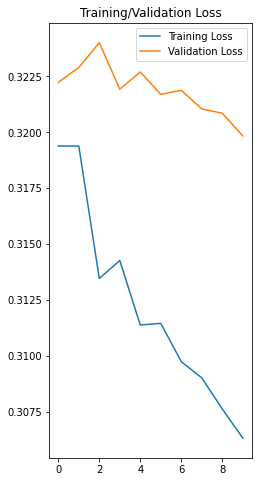

Epoch 1/10
33/33 [==============================] - 0s 11ms/step - loss: 0.3207 - mae: 0.2659 - rmse: 0.3196 - val_loss: 0.2828 - val_mae: 0.2286 - val_rmse: 0.3186
Epoch 2/10
33/33 [==============================] - 0s 9ms/step - loss: 0.3147 - mae: 0.2594 - rmse: 0.3110 - val_loss: 0.2374 - val_mae: 0.1903 - val_rmse: 0.2684
Epoch 3/10
33/33 [==============================] - 0s 9ms/step - loss: 0.3359 - mae: 0.2781 - rmse: 0.3324 - val_loss: 0.2457 - val_mae: 0.2012 - val_rmse: 0.2757
Epoch 4/10
33/33 [==============================] - 0s 9ms/step - loss: 0.3116 - mae: 0.2540 - rmse: 0.3069 - val_loss: 0.2435 - val_mae: 0.1991 - val_rmse: 0.2744
Epoch 5/10
33/33 [==============================] - 0s 9ms/step - loss: 0.3079 - mae: 0.2522 - rmse: 0.3026 - val_loss: 0.2389 - val_mae: 0.1962 - val_rmse: 0.2693

Epoch 00005: val_loss improved from 0.31984 to 0.23894, saving model to my_model_5_0.239.h5
Epoch 6/10
33/33 [==============================] - 0s 9ms/step - loss: 0.3160 - mae: 

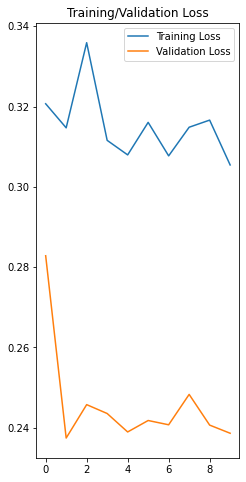

Epoch 1/10
49/49 [==============================] - 0s 10ms/step - loss: 0.3135 - mae: 0.2609 - rmse: 0.3168 - val_loss: 0.3434 - val_mae: 0.2818 - val_rmse: 0.3110
Epoch 2/10
49/49 [==============================] - 0s 8ms/step - loss: 0.3112 - mae: 0.2577 - rmse: 0.3144 - val_loss: 0.3457 - val_mae: 0.2862 - val_rmse: 0.3165
Epoch 3/10
49/49 [==============================] - 0s 8ms/step - loss: 0.3088 - mae: 0.2555 - rmse: 0.3116 - val_loss: 0.3407 - val_mae: 0.2819 - val_rmse: 0.3089
Epoch 4/10
49/49 [==============================] - 0s 8ms/step - loss: 0.3095 - mae: 0.2568 - rmse: 0.3122 - val_loss: 0.3410 - val_mae: 0.2832 - val_rmse: 0.3111
Epoch 5/10
49/49 [==============================] - 0s 9ms/step - loss: 0.3084 - mae: 0.2557 - rmse: 0.3108 - val_loss: 0.3390 - val_mae: 0.2817 - val_rmse: 0.3093

Epoch 00005: val_loss did not improve from 0.23861
Epoch 6/10
49/49 [==============================] - 0s 9ms/step - loss: 0.3085 - mae: 0.2556 - rmse: 0.3106 - val_loss: 0.3385 

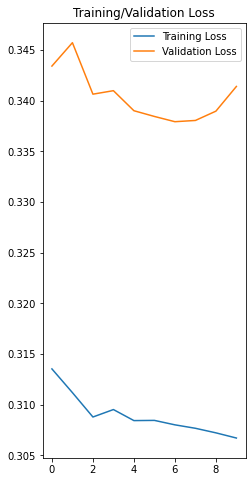

[array([[13.317706]], dtype=float32)]


In [ ]:
################################
################################
########                ########
######## Main Execution ########
########                ########
################################
################################

#Number os variables to use
n_variate = 4
#the dataframes
path=r'daily_diabetes.csv'
df_raw = load_dataset(path)
df_data = prepare_data(df_raw)
df = df_data.copy()

print(df.columns)

print(df.shape)

scaler = data_normalization(df) #scaling data to [-1, 1]


##Optimization

tunning_dict = {
                  1: {'timesteps' : 7, 'multisteps' : 1, 'cv_splits': 3, 'epochs' : 10,  'batch_size' : 5 }#,
                  #2: {'timesteps' : 7, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 50,  'batch_size' : 5 },
                  #3: {'timesteps' : 7, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 100,  'batch_size' : 5 },

                  #
                  #4: {'timesteps' : 8, 'multisteps' : 1, 'cv_splits': 3, 'epochs' : 60,  'batch_size' : 5 },
                  #5: {'timesteps' : 8, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 5 },
                  #6: {'timesteps' : 8, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 5 },
                  #
                  #7: {'timesteps' : 10, 'multisteps' : 1, 'cv_splits': 3, 'epochs' : 50,  'batch_size' : 8 },
                  #8: {'timesteps' : 10, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 8 },
                  #9: {'timesteps' : 10, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 8 }

  }
  # record da history de cada modelo
record = {}

#tunning the model cycle
for t in tunning_dict:
   # print(record[r])
   # fitting the model
   timesteps = tunning_dict[t]['timesteps']
   epochs = tunning_dict[t]['epochs']
   batch_size = tunning_dict[t]['batch_size']
   multisteps = tunning_dict[t]['multisteps']
   cv_splits = tunning_dict[t]['cv_splits']
   # print(timesteps,epochs,batch_size,cv_splits)

   X, y = to_supervised(df, timesteps)

   model = build_model(timesteps, n_variate)
   model, history = compile_and_fit(model, epochs, batch_size)
   # print("df: ",df.shape," timesteps",timesteps," multisteps ",multisteps)
   forecasts = forecast(model, df, timesteps, multisteps, scaler)

   print(forecasts)

   prev = []

    # plot do valor previsto da ação de Open
    #for f in forecasts:
    #  prev.append(f[0][0])

    #print(prev)
    #plot_forecast(df_raw, prev)


   record[t] = history


  #Put the resulting metrics in a file
id_tunning = 1
id_split = 1

final_dict = {}

for r in record:
    # print(tunning_dict[1]['epochs'])
    loss = []
    mae = []
    rmse = []
    val_loss = []
    val_mae = []
    val_rmse = []

    for h in record[r]:
      # print("Tunning ID:  ",id_tunning," Split ID: ",id_split)
      # plot_learning_curves(h, tunning_dict[id_tunning]['epochs'])
      # ['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse']
      # print("loss: ",sum(h.history['loss'])/len(h.history['loss'])," MAE: ",sum(h.history['mae'])/len(h.history['mae'])," RMSE: ",sum(h.history['rmse'])/len(h.history['rmse'])," VAL_LOSS: ",sum(h.history['val_loss'])/len(h.history['val_loss'])," VAL_MAE: ",sum(h.history['val_mae'])/len(h.history['val_mae'])," VAL_RMSE: ",sum(h.history['val_rmse'])/len(h.history['val_rmse']))
      loss.append(sum(h.history['loss']) / len(h.history['loss']))
      mae.append(sum(h.history['mae']) / len(h.history['mae']))
      rmse.append(sum(h.history['rmse']) / len(h.history['rmse']))
      val_loss.append(sum(h.history['val_loss']) / len(h.history['val_loss']))
      val_mae.append(sum(h.history['val_mae']) / len(h.history['val_mae']))
      val_rmse.append(sum(h.history['val_rmse']) / len(h.history['val_rmse']))
      id_split += 1
    id_split = 1

    final_dict[id_tunning] = [sum(loss) / len(loss), sum(mae) / len(mae), sum(rmse) / len(rmse),
                              sum(val_loss) / len(val_loss), sum(val_mae) / len(val_mae), sum(val_rmse) / len(val_rmse)]

    id_tunning = id_tunning + 1




In [ ]:
for f in final_dict:
    print("Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE")
    print("ID tunning: ",f, " Valores: ",final_dict[f],"\n")

final_df = pd.DataFrame.from_dict(final_dict, orient='index')
final_df.columns = ['Loss','MAE','RMSE','VAL_LOSS','VAL_MAE','VAL_RMSE']
final_df

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  1  Valores:  [0.3121054192384084, 0.2577810873587926, 0.3154854704936345, 0.30273968279361724, 0.2506869296232859, 0.30626534521579746] 



,Loss,MAE,RMSE,VAL_LOSS,VAL_MAE,VAL_RMSE
1,0.312105,0.257781,0.315485,0.30274,0.250687,0.306265


In [ ]:
#Results metrics to a file
final_df.to_csv(r"resultados_lstm_diabetes.csv",index=True)